In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [2]:
# read in dataset Jill
dset = pd.read_csv('Lisa2Data_H.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

4021
6.701666666666667


In [3]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) # select which data points; used to be [:8000]
#d = pd.DataFrame(data = dset[0:25000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/10) # add timestamp assuming 10 samples / second
#print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

d['bmav'] = d['belly'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])
d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])
d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

d['brmav'] = d['brlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['bfmav'] = d['bflast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['brfmav'] = (d['brmav']+ d['bfmav'])/2

#Breathing rate averages Chest and Belly
d['cbrfmav'] = d['brfmav']*0.1+d['rfmav']*0.9

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

In [4]:
f = d

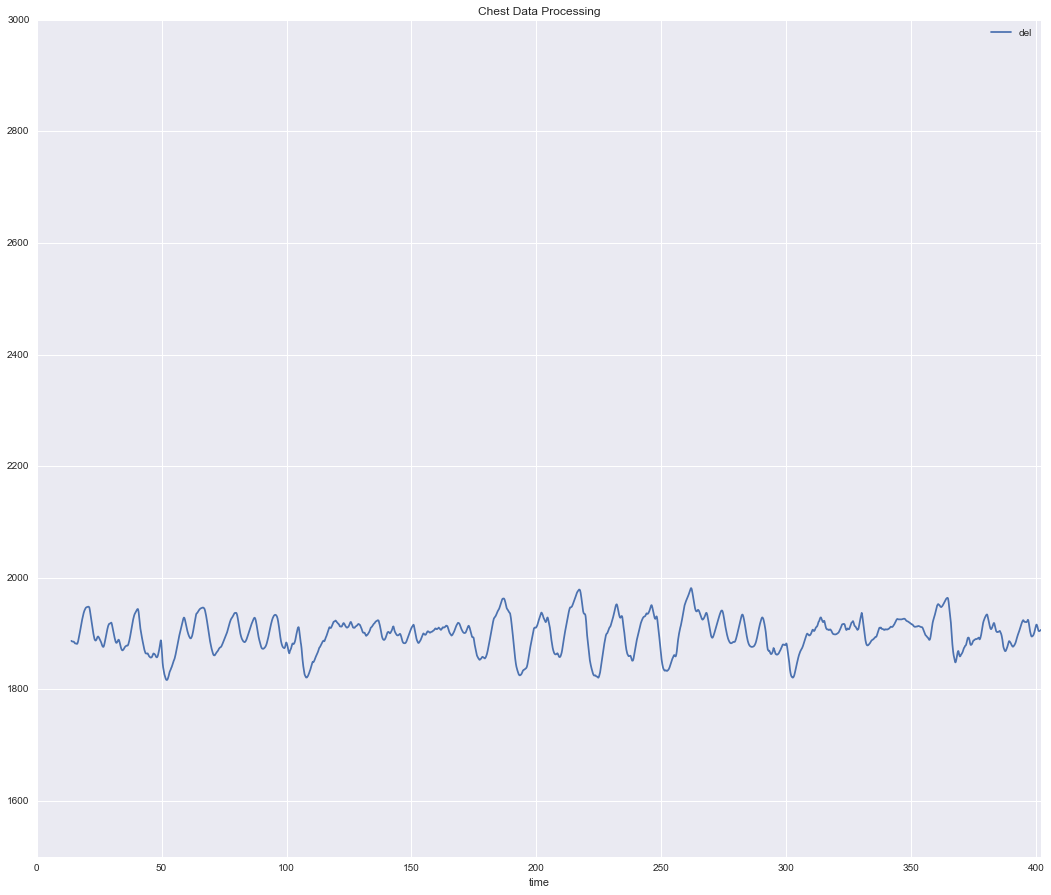

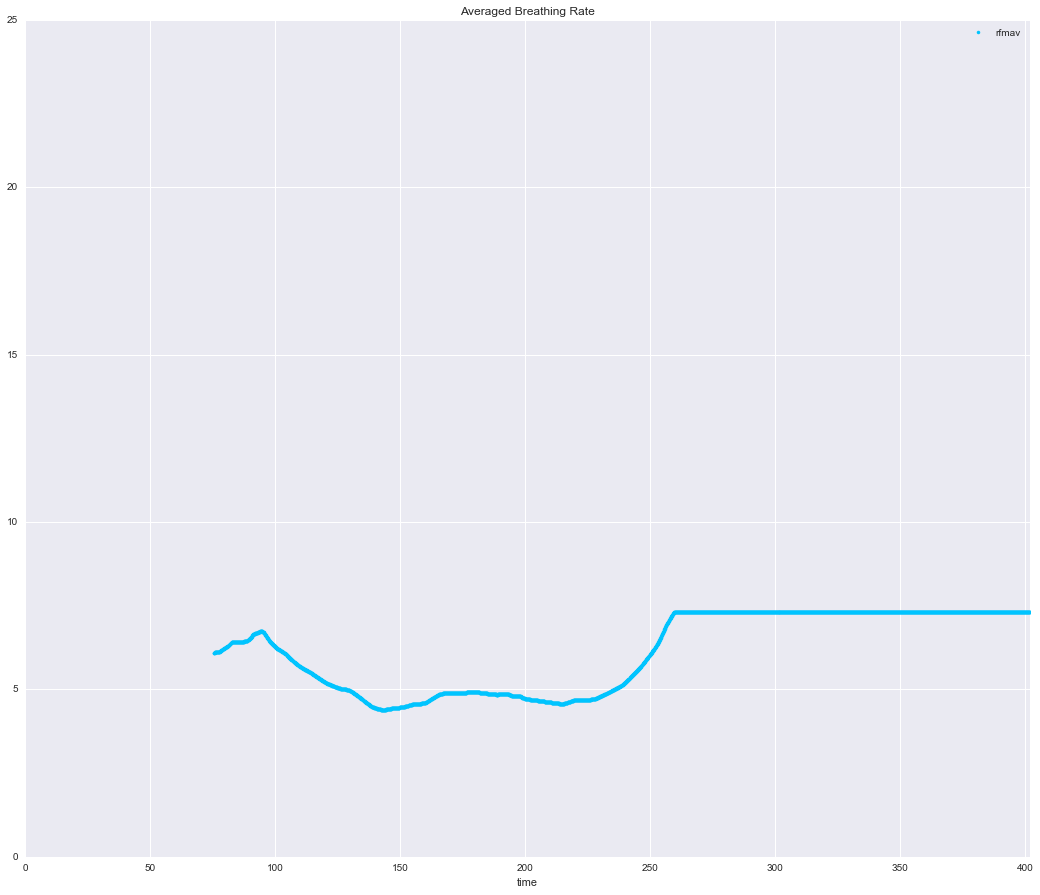

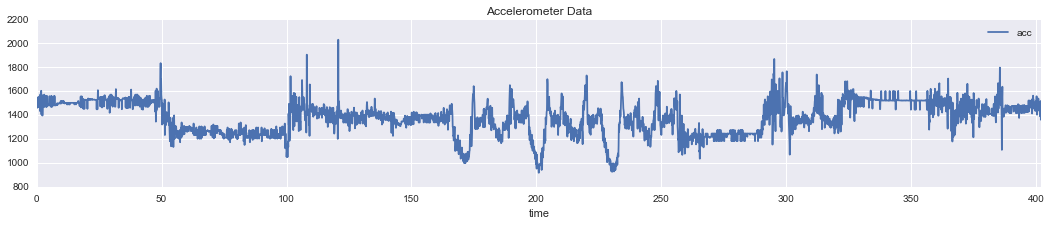

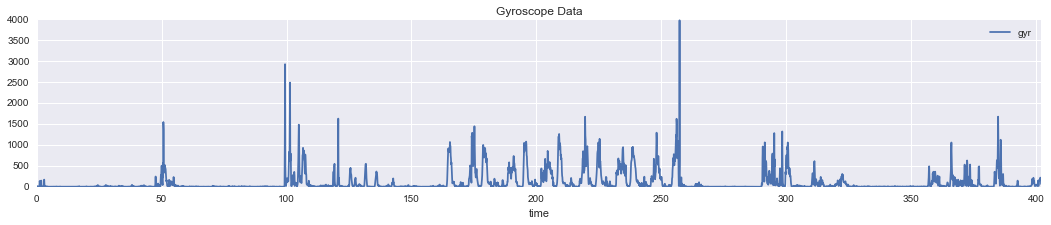

In [5]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1500,3000), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,25), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [6]:
print(d[::1000]) # every thousandth line of the processed dataset

      index  chest  belly  ax  ay  az  gx  gy  gz   time  ...       fmav  \
0         0   3045   3211   1  -3  39   2   1   0    0.0  ...        NaN   
1000   1000   2936   3246  -8 -31   5  11  -1  -1  100.0  ...   7.046389   
2000   2000   2917   3185 -30  -5   8   6   7   2  200.0  ...   5.499458   
3000   3000   2954   3238  -7  -9  39  24  -7   6  300.0  ...   5.084746   
4000   4000   3045   3252 -13  22  29  -4   3  -4  400.0  ...   5.084746   

         rfmav     brmav      bfmav    brfmav   cbrfmav   acc  gyr    b1    b2  
0          NaN       NaN        NaN       NaN       NaN  1531    5  1900  1600  
1000  6.269357  6.958539   4.780178  5.869358  6.229357  1050  123  1900  1600  
2000  4.727425  7.094015   7.461140  7.277578  4.982440   989   89  1900  1600  
3000  7.304278  5.769231  11.764706  8.766968  7.450547  1651  661  1900  1600  
4000  7.304278  5.769231  11.764706  8.766968  7.450547  1494   41  1900  1600  

[5 rows x 43 columns]


In [7]:
d.head(6000)

index  chest  belly  ax  ay  az  gx  gy  gz   time  ...       fmav  \
0         0   3045   3211   1  -3  39   2   1   0    0.0  ...        NaN   
1         1   3045   3210   0  -4  39   0  -1  -1    0.1  ...        NaN   
2         2   3034   3210   1  -4  38  -2  -1  -2    0.2  ...        NaN   
3         3   3028   3209   1  -4  39  -2  -1  -2    0.3  ...        NaN   
4         4   3023   3204   1  -5  39  -1  -1  -1    0.4  ...        NaN   
5         5   3018   3202   0  -4  39  -2   0  -2    0.5  ...        NaN   
6         6   3012   3203   0  -5  39  -1  -1  -1    0.6  ...        NaN   
7         7   3010   3203   0  -5  38  -1  -1  -1    0.7  ...        NaN   
8         8   3010   3206   1  -5  39  -1  -1  -1    0.8  ...        NaN   
9         9   3022   3210   0  -5  38  -1  -1  -1    0.9  ...        NaN   
10       10   3034   3212   1  -5  39  -1  -1  -1    1.0  ...        NaN   
11       11   3042   3214   1  -5  39  -3   0  -2    1.1  ...        NaN   
12       12   3054   3210   1  -6  39 -10  -6  -2    1.2  ...        NaN   
13       13   3060   3217   1  -8  37  -7  -2  -3    1.3  ...        NaN   
14       14   3075   3217   2  -8  38  -4   0  -1    1.4  ...        NaN   
15       15   3080   3220   2  -7  39  -3  -2  -3    1.5  ...        NaN   
16       16   3081   3222   1  -7  38  -1  -3  -2    1.6  ...        NaN   
17       17   3083   3224   1  -7  38  -3   0   1    1.7  ...        NaN   
18       18   3062   3203  -1  -9  39 -12   0   2    1.8  ...        NaN   
19       19   3034   3183   3 -10  36  -7  -1   1    1.9  ...        NaN   
20       20   3005   3183   0 -10  38  -3   0   0    2.0  ...        NaN   
21       21   2998   3186   1  -9  37   0  -1   0    2.1  ...        NaN   
22       22   2987   3186   1 -11  38  -1   1   0    2.2  ...        NaN   
23       23   2986   3187   0 -10  36  -1   0  -1    2.3  ...        NaN   
24       24   2982   3183   0 -10  37   0  -2  -2    2.4  ...        NaN   
25       25   2977   3183   1 -10  38   2  -1  -1    2.5  ...        NaN   
26       26   2980   3187   2 -10  37  -1   0  -1    2.6  ...        NaN   
27       27   2990   3191   2 -10  37  -1   0   0    2.7  ...        NaN   
28       28   2993   3192   0 -11  37   0   0   0    2.8  ...        NaN   
29       29   2995   3194   0 -10  37   3  -2  -2    2.9  ...        NaN   
...     ...    ...    ...  ..  ..  ..  ..  ..  ..    ...  ...        ...   
3991   3991   3011   3214  -8  23  30  -1  11   1  399.1  ...   5.084746   
3992   3992   3017   3216  -8  23  30  -1  12  -1  399.2  ...   5.084746   
3993   3993   3021   3220  -9  23  29   0   9  -2  399.3  ...   5.084746   
3994   3994   3028   3225 -10  23  29   0   7  -2  399.4  ...   5.084746   
3995   3995   3034   3236 -11  23  29  -1   3  -3  399.5  ...   5.084746   
3996   3996   3047   3246 -11  23  29  -1   2  -3  399.6  ...   5.084746   
3997   3997   3046   3252 -11  23  28  -3   2  -4  399.7  ...   5.084746   
3998   3998   3050   3255 -12  23  29  -3   4  -4  399.8  ...   5.084746   
3999   3999   3049   3254 -12  22  29  -3   4  -4  399.9  ...   5.084746   
4000   4000   3045   3252 -13  22  29  -4   3  -4  400.0  ...   5.084746   
4001   4001   3035   3245 -14  22  29  -6  -2   0  400.1  ...   5.084746   
4002   4002   3021   3234 -14  20  31  -5  -5   0  400.2  ...   5.084746   
4003   4003   3009   3228 -13  21  30   0  -5   2  400.3  ...   5.084746   
4004   4004   2996   3222 -11  21  29  -1  -4   0  400.4  ...   5.084746   
4005   4005   2987   3216 -12  21  30  -4   3  -1  400.5  ...   5.084746   
4006   4006   2982   3215 -12  20  30  -2   6  -2  400.6  ...   5.084746   
4007   4007   2980   3216 -12  20  30   3   9  -1  400.7  ...   5.084746   
4008   4008   2975   3215 -15  22  27   5  11  -1  400.8  ...   5.084746   
4009   4009   2980   3224 -16  21  29   1   4   3  400.9  ...   5.084746   
4010   4010   2996   3228 -16  21  28   0  -2   4  401.0  ...   5.084746   
4011   4011   3003   3234 -15  22  28  -2  -8   5  401